# Facies detection model


Seismic horizon is a change in rock properties across a boundary between two layers of rock, particularly seismic velocity and density. Such changes are visible in seismic images (even for an untrained eye), and could be automatically detected. This notebook demonstrates how to build convolutional neural network that detects all of the horizonts on the given cube.

* [Dataset](#dataset)
* [Model architecture](#architecture)
* [Training](#training)
* [Validation](#validation)
* [Criticism](#criticism)
* [Conclusion](#conclusion)
* [Suggestions for improvements](#suggestions)


<a id='dataset'></a>

# Dataset

We use one seismic cube, in particular, `Cube 3`, for training: it has 20 inlines with 5 hand-labelled facies. Example image can be seen below.


Importantly, as any of the cubes is too big to fit into the GPU memory, we must cut small crops out of it in order to train the model. This changes whole pipeline of research: we need convenient methods of:
* splitting seismic cubes into crops of desired shape
* lazy loading crops into memory (with quite harsh memory constraints)
* training model on labeled crops
* predicting with trained model on unlabeled crops
* assemble predictions back into the whole cube

`Seismiqb` package provides exactly this. Some examples of ready-to-use pipelines can be found [here.](./../tutorials/2.%20Batch.ipynb)

**Note:** we heavily rely on [BatchFlow](https://github.com/analysiscenter/batchflow) to define sophisticated neural network architectures with just a few lines of code.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import segyio

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import NumpySampler as NS
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import *
from seismiqb.batchflow.models.tf.losses import dice_batch
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset, \
                     plot_loss, plot_stratum_predictions, plot_images_transparent

from tqdm import tqdm
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Выбор GPU: ноутбук использует только одну видеокарту
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


First of all, we index `.hdf5` cubes with the help of [FilesIndex](https://analysiscenter.github.io/batchflow/intro/dsindex.html). `SeismicCubeset` provides lots of processing actions for different types of seismic information (cubes in different formats, labels).

In [2]:
path_data = '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5'

dsi = FilesIndex(path=[path_data], no_ext=True)
ds = SeismicCubeset(dsi)

Now we need to get more information about dataset and lay out inner structure. That is done by `load` method of `SeismicCubeset`, that is chain-calling different functions under the hood: one to infer cube geometries, three to parse `.txt` labels and convert them into format with quick access, and, finally, create `Sampler`: that is an entity that allows to generate crop locations exactly where we want them to be. All of these are explained in great details in [this](./../tutorials/1.%20Cubeset.ipynb) tutorial.

We use `bins` argument in order to create finer grid on `inlines`: that is necessary because we only have 20 labeled slides.

In [3]:
%%time
ds = ds.load(horizon_dir='/RAW_FACIES/*', bins=[2737, 130, 20])
# 6 seconds

CPU times: user 6.35 s, sys: 216 ms, total: 6.57 s
Wall time: 6.57 s


Now we can look at out data:

Image from P_cube


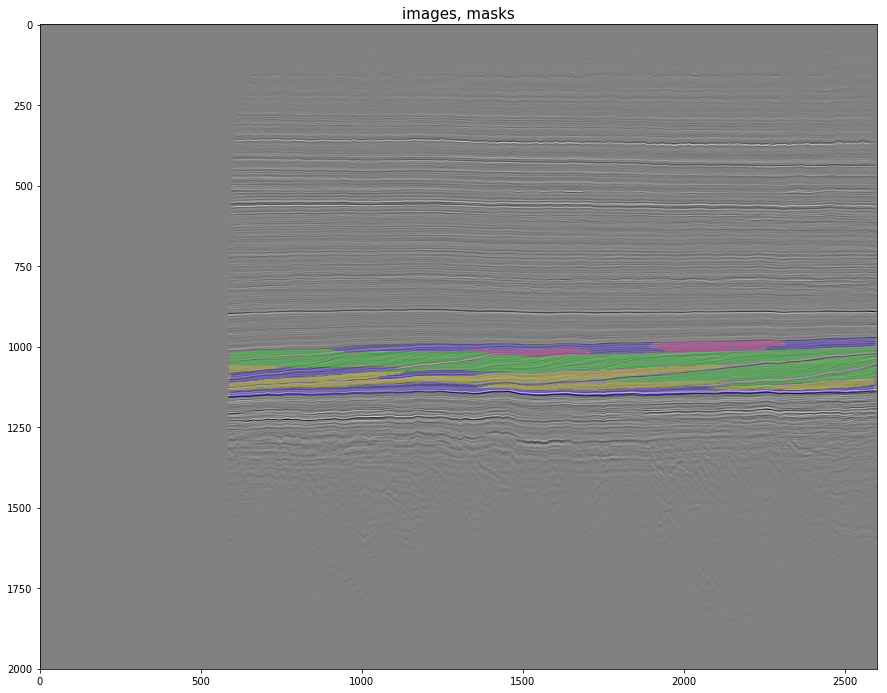

In [4]:
ds.show_slide(idx=0, n_line=2531, plot_mode='facies')

As we can see, only a small fracion of slide is labeled: most of the labeles are located at ~1000-1200 depth. It might be helpful to show our model data that is at other location, so we create a mixture of samplers: the first is based on labels, the second is uniform across heights.

In [5]:
ds.modify_sampler('train_sampler', low=0.0, high=1.0, finish=False)

ds.wide_sampler = (ds.sampler | 
                   0.3 & (ds.sampler.apply(lambda points: points[:, :3]) & NS('u', low=0., high=1.)))

ds.modify_sampler('train_sampler', mode='xline', low=0.0, high=0.75,
                  src='wide_sampler', finish=True)
ds.modify_sampler('test_sampler', mode='xline', low=0.9, high=1,
                  src='wide_sampler', finish=True)

We can visualize potentialy sampled points by using `show_sampler` method:

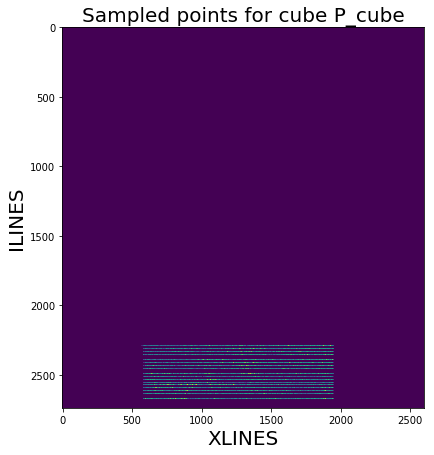

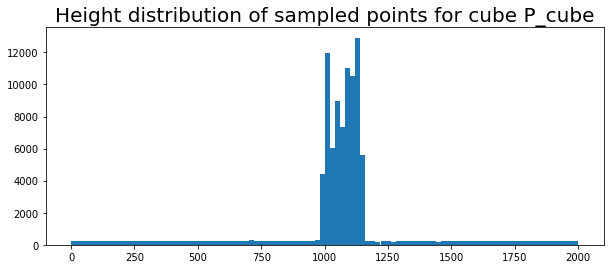

Unique inlines are: [2291 2311 2331 2351 2371 2391 2411 2431 2451 2471 2491 2511 2531 2551
 2571 2591 2611 2631 2651 2671]


In [6]:
ds.show_sampler(src_sampler='train_sampler', show_unique=True)

<a id='architecture'></a>

# Model architecture

We use convolutional neural network in `EncoderDecoder` fashion and train on crops of (256, 256, 1) size:
* First of all, initial crop is passed through convolution-batchnorm-activation blocks twice along xlines/heights dimensions
* Then, we encode crop by applying ResBlocks 5 times with max-pooling in-between
* `DenseNet block` is applied in the bottleneck
* Initial shape of the block is restored by transposed convolutions with convolutions+batchnorm+activation(ReLU) blocks with residuals in-between

Multiple things are worth noting. Most importantly, model percieves every crop (a 3-d entity) as sequence of 2-d images stacked one after the other, and every convolution that is used is 2D. Every max-pooling in the network is of size and stride 2, effectively halving the resolution of its inputs.

In [7]:
# Global constants
EPOCHS = 500
NUM_CROPS = 128
LR = 0.01
CROP_SHAPE = (1, 256, 256) # i, x, h

MODEL_SHAPE = (CROP_SHAPE[1], CROP_SHAPE[2], CROP_SHAPE[0])

In [8]:
# Model configuration
model_config = {
    # Shapes and orders
    'inputs/images/shape': (None, None, 1),
    'inputs/masks/transform': 'ohe',
    'inputs/masks/classes': 6,
    'inputs/masks/shape': (None, None), 
    'initial_block/inputs': 'images',
    'common/data_format': 'channels_last',
    # Model layout
    'initial_block': {'layout': 'cna RRcna+ Rcna++',
                      'filters': [32, 32, 32],
                      'kernel_size': 5, },
    'body/encoder': {'num_stages': 5,
                     'blocks': {'base': ResNet.block,
                                'filters': [32, 64, 128, 256, 256],
                                'se_block': {'ratio': 4},}
                    },
    'body/embedding': {'base': DenseNet.block,
                       'layout': 'cna',
                       'growth_rate': 16,
                       'num_layers': 5,
                       'bottleneck': True,
                       'skip': True,
                      },
    'body/decoder': {'num_stages': 5,
                     'upsample': {'layout': 'tna',
                                  'kernel_size': 2,},
                     'blocks': {'base': ResNet.block,
                                'filters': [256, 128, 64, 32, 16, 16],
                                'se_block': {'ratio': 8},
                               }
                    },
    'head': {'layout': 'cna cna',
             'filters': [16, 8]},
    # Train configuration
    'loss': 'dice',
    'microbatch': 2,
    'optimizer': 'Adam',
    'decay': {'name': 'exp',
              'learning_rate': LR,
              'decay_rate': 1/2,
              'decay_steps': 500},
}

pipeline_config = {
    'model': EncoderDecoder,
    'model_config': model_config,
}

<a id='training'></a>

# Training

Neural network is trained on crops of fixed shape. Pipeline consists of following steps:
* First of all, we initialize all the pipeline variables, that we need, and the model itself
* Then, we create positions of crops, then load actual data and labels for it. Data is immediately scaled to $[0, 1]$ range in order to normalize values from different cubes
* Right after, multiple augmentations are applied to simulate different distortions and make model robust to them
* Model weights update

In [9]:
train_template = (Pipeline(config=pipeline_config)
                  # Initialize pipeline variables and model
                  .init_variable('current_loss')
                  .init_variable('loss_history', [])
                  .init_model('dynamic', C('model'), 'ED', C('model_config'))
                  # Load data/masks
                  .crop(points=D.train_sampler(NUM_CROPS),
                        shape=CROP_SHAPE, loc=(-1, 0, 0))
                  .load_cubes(dst='images')
                  .create_masks(dst='masks')
                  .rotate_axes(src=['images', 'masks'])
                  .scale(mode='normalize', src='images')
                  # Augmentations
                  .additive_noise(scale=0.001,
                                  src='images', dst='images', p=0.2)
                  .rotate(angle=P(R('normal', 0, 5)),
                          src=['images', 'masks'])
                  .scale_2d(scale=P(R('uniform', 0.85, 1.15)),
                            src=['images', 'masks'], p=0.4)
                  .add_axis(src='images', dst='images')
                  .cutout_2d(patch_shape=P(R('uniform', 5, 15, size=2)),
                             n=P(R('uniform', 1, 10)),
                             src='images', p=0.2)
                  .apply_transform(lambda a: a.astype(np.int32).squeeze(),
                                   src='masks', dst='masks')
                  # Training
                  .train_model('ED', 
                               fetches='loss',
                               images=B('images'),
                               masks=B('masks'),
                               save_to=V('loss_history', mode='a'))
                 )

# Add dataset to pipeline
train_pipeline = train_template << ds

Every batch contains 64 crops of (256, 256, 1) size. Model is trained for 500 epochs by `Adam` optimizer with default parameters and [exponential learning rate decay](https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/exponential_decay).

In [10]:
%%prun -l 8
# Training loop
train_pipeline.run(D.size, n_iters=EPOCHS,
                   bar=True, bar_desc=W(V('loss_history')[-1].format('Loss is: {:7.7}')))

Loss is: -0.09071743: 100%|██████████| 500/500 [1:46:56<00:00, 12.81s/it]

         102377206 function calls (100584984 primitive calls) in 6416.001 seconds

   Ordered by: internal time
   List reduced from 1749 to 8 due to restriction <8>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    33002 2866.476    0.087 2866.476    0.087 {built-in method _pywrap_tensorflow_internal.TF_SessionRun_wrapper}
  1698416 1405.459    0.001 1405.459    0.001 {method 'acquire' of '_thread.lock' objects}
    22381  751.330    0.034  751.330    0.034 {built-in method numpy.concatenate}
    10992  339.853    0.031  339.853    0.031 {method 'copy' of 'numpy.ndarray' objects}
   179120  209.393    0.001  209.393    0.001 {warpAffine}
     1820  205.733    0.113  206.013    0.113 {method 'choice' of 'mtrand.RandomState' objects}
     1820  155.596    0.085 1333.601    0.733 sampler.py:547(sample_histodd)
   195902   65.893    0.000   65.893    0.000 {built-in method numpy.arange}

Loss against iterations:

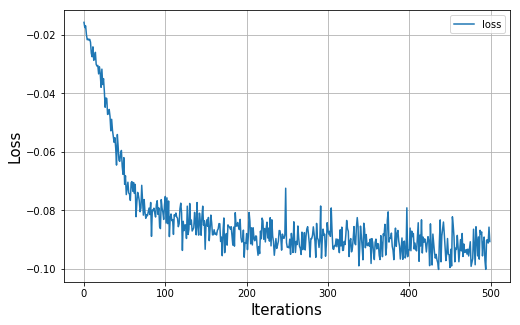

In [11]:
plot_loss(train_pipeline.v('loss_history'), ['loss'])

As we can see, loss function quickly starts to plateau after just one hour of training. Relatively high variance suggests that model can benefit from bigger batch size.

Time to save trained model:

In [12]:
# model_save_dir = '/notebooks/SEISMIC_DATA/SAVED/MODELS/FACIES_DETECTION_DEMO'
# train_pipeline.save_model_now('ED', model_save_dir)
# load_config = {'load/path': model_save_dir}

<a id='validation'></a>

# Validation
## Validation on crops
Now, we want to check performance of our model on unseen part of the cubes. 

In [13]:
# Validation pipeline: no augmentations
val_template = (Pipeline(config=pipeline_config)
                # Load model from disk/import it from training pipeline
                .import_model('ED', train_pipeline) 
#                 .init_model('dynamic', TFModel, 'loaded_model', load_config)   
                # Load data/masks
                .crop(points=D('train_sampler')(8),
                      shape=CROP_SHAPE, loc=(-1, 0, 0))
                .load_cubes(dst='images')
                .create_masks(dst='masks')
                .rotate_axes(src=['images', 'masks'])
                .scale(mode='normalize', src='images')
                .apply_transform(lambda a: a.astype(np.int32).squeeze(),
                               src='masks', dst='masks')
                # Predict with model
                .predict_model('ED', 
                           fetches=['targets', 'predictions'],
                           images=B('images'), masks=B('masks'),
                           save_to=[B('targets'), B('predictions')])
                 )

# Add dataset to pipeline
val_pipeline = val_template << ds

In [14]:
val_batch = val_pipeline.next_batch(D('size'))

We can just plot images of crops, hand-labeled masks and model predictions:

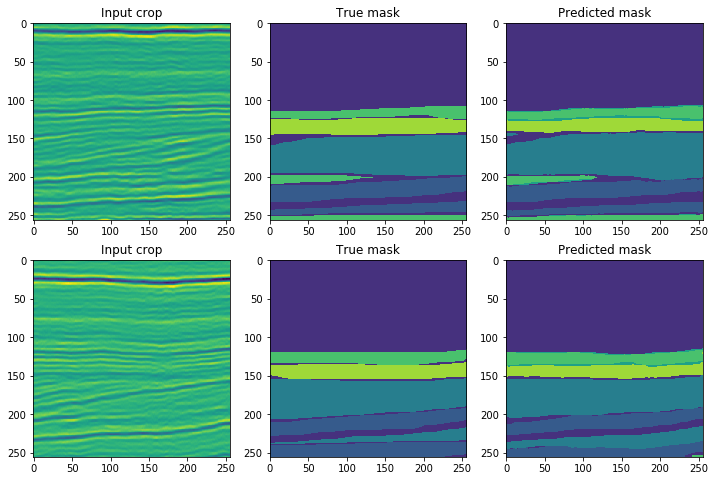

In [15]:
plot_stratum_predictions(val_batch.images,
                         val_batch.targets,
                         val_batch.predictions, 2)

## Validation on slides
It is way easier to analyse results when multiple crops are aggregated back into bigger picture. Method `make_grid`, paired with action `assemble_crops`, does exactly that:

In [16]:
test_template = (Pipeline()
                # Load data/masks
                .load_component([D('labels'), D('geometries')],
                             ['labels', 'geometries'])
                .crop(points=L(D('grid_gen')),
                      shape=CROP_SHAPE, loc=(-1, 0, 0))
                .load_cubes(dst='images')
                .create_masks(dst='masks')
                .scale(mode='normalize', src='images')
                .rotate_axes(src=['masks', 'images'])
                .apply_transform(lambda a: a.astype(np.int32).squeeze(),
                                 src='masks', dst='masks')
                # Predicting with model
                .import_model('ED', train_pipeline) 
#                 .init_model('dynamic', TFModel, 'ED', load_config)    
                .init_variables({'images': {'default': list()},
                                 'masks': {'default': list()},
                                 'predictions': {'default': list()},
                                 'predictions_amax': {'default': list()},
                                 'masks_3d': {'default': list()}
                                })
                .predict_model('ED',
                            fetches=['images', 'masks', 'predictions'],
                            images=B('images'), masks=B('masks'),
                            save_to=[V('images', mode='e'),
                                     V('masks', mode='e'),
                                     V('predictions', mode='e')])
                .update_variable('predictions_amax',
                                 L(lambda lst: [pred.argmax(axis=-1)[..., np.newaxis] for pred in lst])
                                 (V('predictions')))
                .update_variable('masks_3d',
                                 L(lambda lst: [targets[..., np.newaxis] for targets in lst])
                                 (V('masks')))
                # Aggregating crops into inline
                .assemble_crops(src=V('images'), dst='assembled_img',
                                grid_info=D('grid_info'))
                .assemble_crops(src=V('predictions_amax'), dst='assembled_pred',
                                grid_info=D('grid_info'))
                .assemble_crops(src=V('masks_3d'), dst='assembled_mask',
                                grid_info=D('grid_info'))
                )

In [17]:
ds = ds.make_grid(ds.indices[0], CROP_SHAPE,
                  [2330, 2331], [0, 2598], [1000, 1170])

test_pipeline = test_template << ds

for _ in tqdm(range(ds.grid_iters)):
    test_batch = test_pipeline.next_batch(D('size'), n_epochs=None)

100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


Time to plot the results! First image shows predictions, the next shows true labels. For convenience, we resize all images.

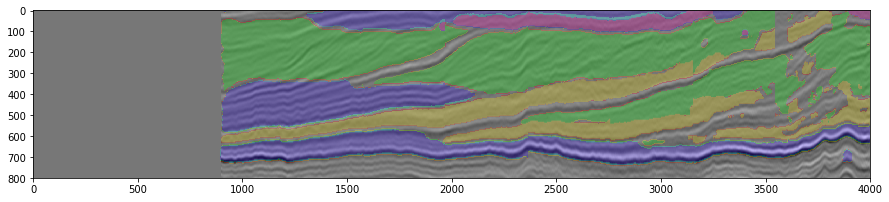

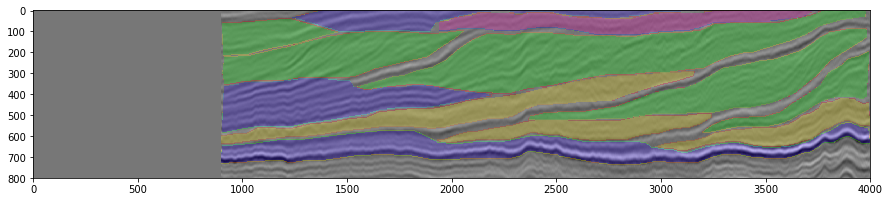

In [18]:
big_img, big_mask, big_pred  = (np.squeeze(test_batch.assembled_img),
                                np.squeeze(test_batch.assembled_mask).astype(int),
                                np.squeeze(test_batch.assembled_pred).astype(int))

from scipy.misc import imresize as resize
big_img = resize(big_img, (4000, 800))
big_mask = resize(big_mask, (4000, 800))
big_pred = resize(big_pred, (4000, 800))

plot_images_transparent([big_img, big_pred], '', None)
plot_images_transparent([big_img, big_mask], '', None)

We can use `Dice-coefficient` as a simple metric to compare our predictions to ground truth:

In [19]:
def np_onehot(array, num_classes=None):
    num_classes = num_classes or np.max(array) + 1
    return np.eye(num_classes)[array]

def np_dice(y_true, y_pred, num_classes=None, epsilon=1e-16):
    y_true = np_onehot(y_true, num_classes)
    y_pred = np_onehot(y_pred, num_classes)

    y_true_flatten = np.asarray(y_true).astype(np.bool)
    y_pred_flatten = np.asarray(y_pred).astype(np.bool)

    return (2. * np.sum(y_true_flatten * y_pred_flatten)) /\
           (np.sum(y_true_flatten) + np.sum(y_pred_flatten) + epsilon)

In [20]:
big_mask, big_pred  = (np.squeeze(test_batch.assembled_mask).astype(int),
                       np.squeeze(test_batch.assembled_pred).astype(int))

coeff = np_dice(big_mask, big_pred)
print('Dice-coefficient on assembled slide is: {}'.format(coeff))

Dice-coefficient on assembled slide is: 0.8606688402843816


In [21]:
idx = 1
targets, predictions =val_batch.targets[idx].astype(int),  val_batch.predictions[idx].astype(int)
targets, predictions = np.argmax(targets, axis=-1), np.argmax(predictions, axis=-1)

coeff = np_dice(targets, predictions, num_classes=6)
print('Dice-coefficient on {} crop is: {}'.format(idx, coeff))

Dice-coefficient on 1 crop is: 0.9241180419921875


In [22]:
dices = []
for idx in range(len(val_batch)):
    targets, predictions =val_batch.targets[idx].astype(int),  val_batch.predictions[idx].astype(int)
    targets, predictions = np.argmax(targets, axis=-1), np.argmax(predictions, axis=-1)

    coeff = np_dice(targets, predictions, num_classes=6)
    dices.append(coeff)
print('Average Dice-coefficient on crops: {}'.format(np.mean(dices)))

Average Dice-coefficient on crops: 0.9528579711914062


<a id='criticism'></a>
# Criticism

As of now, model predictions are evaluated mostly based on visual analysis. While it is enough to validate that model successfully outputs reasonable predictions, we need to define a metric that reflects our understanding of what a good labeling is. Also, we need methods of converting predictions from images to dictionaries/`txt`-files.


It is also important that our dataset is very small:it consists only of 20 inlines, and even on them the labeled area is quite small.